In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms

### Data Loader

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.RandomVerticalFlip(p=0.3)
])

In [ ]:
trans = transforms.Compose([
    transforms.ToTensor()
])

In [ ]:
train_data = torchvision.datasets.CIFAR10(root='data/', train=True, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12810388.61it/s]


Extracting data/cifar-10-python.tar.gz to data/


In [ ]:
len(train_data)

50000

In [ ]:
test_data = torchvision.datasets.CIFAR10(root='data_/', train=False, transform=None, download=True)

100%|██████████| 170498071/170498071 [00:12<00:00, 13127287.36it/s]


Extracting data_/cifar-10-python.tar.gz to data_/


In [ ]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [ ]:
import random

count = random.sample(range(1, 1000), k=10)
eval_data =[]
for i in count:
    eval_data.append(test_data[i])

### Get Model

In [ ]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
    def forward(sefl, x):
        return x

model = torchvision.models.resnet18(pretrained=False)

for param in model.parameters():
    param.requires_grad=False

model.avgpool = Identity()

model.fc = nn.Sequential(
    nn.Linear(512, 64),

    nn.Linear(64, 10)
)

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Training and Testing

In [ ]:
def train_step(
    model: torch.nn.Module,
    dataset: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer):

    ### 
    train_loss, train_acc = 0, 0

    model.train()

    for batch, (X, y) in enumerate(dataset):
        ###
        X, y = X.to(device), y.to(device)
        # 1
        y_pred = model(X)
        # 2
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        # 3
        optimizer.zero_grad()
        # 4
        loss.backward()
        # 5
        optimizer.step()

        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y==y_pred_class).sum().item() / len(y_pred_class)

    # metric
    train_loss = train_loss / len(dataset)
    train_acc =train_acc / len(dataset)

    return train_loss, train_acc

In [ ]:
def test_step(
    model: torch.nn.Module,
    dataset: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module):
  
    ###
    test_loss, test_acc =0, 0
    model.eval()

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataset):
            ###
            X, y = X.to(device), y.to(device)
            #1
            test_pred = model(X)
            #2
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = torch.argmax(torch.softmax(test_pred, dim=1), dim=1)
            test_acc += (test_pred_class==y).sum().item() / len(test_pred_class)

        # metric
        test_loss = test_loss / len(dataset)
        test_acc = test_acc / len(dataset)
        return test_loss, test_acc

In [ ]:
def training(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epochs: int):
  
    ###
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}


    for epoch in range(epochs):
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn)

        print(f'Epoch: {epoch+1} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.2f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.2f}')

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [ ]:
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(params=model.parameters(), lr=0.001)

model_results = training(model=model, train_dataloader=train_loader, test_dataloader=test_loader,
                      loss_fn=loss_fn, optimizer=optimizer, epochs=epochs)

Epoch: 1 | train_loss: 2.0063 | train_acc: 0.27 | test_loss: 1.9603 | test_acc: 0.29
Epoch: 2 | train_loss: 1.9869 | train_acc: 0.28 | test_loss: 1.9792 | test_acc: 0.28
Epoch: 3 | train_loss: 1.9818 | train_acc: 0.28 | test_loss: 1.9656 | test_acc: 0.28
Epoch: 4 | train_loss: 1.9791 | train_acc: 0.28 | test_loss: 1.9513 | test_acc: 0.30
Epoch: 5 | train_loss: 1.9745 | train_acc: 0.29 | test_loss: 1.9683 | test_acc: 0.28


In [ ]:
model.eval()
with torch.inference_mode():
    X = eval_data[0][0]
    X = trans(X)
    X = X.unsqueeze(dim=0)
    y = eval_data[0][1]

    X = X.to(device)
    
    y_pred = model(X)

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)

    print(y_pred_class)
    print(y)

tensor([8], device='cuda:0')
9


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
X = X.to('cpu')

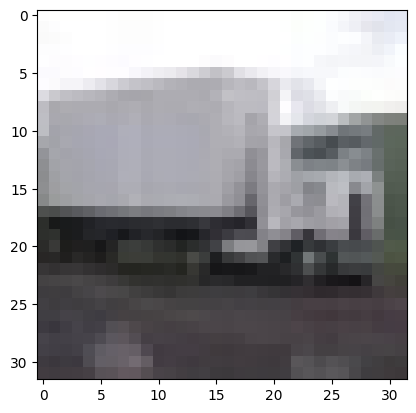

In [ ]:
plt.imshow(X.squeeze().permute(1,2,0))

In [ ]:
class_name = train_data.classes
class_name

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']